In [2]:
import os
import re
import pickle
import string
import unicodedata
from random import randint

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from wordcloud import STOPWORDS, WordCloud

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Embedding, TimeDistributed

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install -q contractions==0.0.48

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 5.8 MB/s eta 0:00:00


In [5]:
from contractions import contractions_dict

for key, value in list(contractions_dict.items())[:10]:
    print(f'{key} == {value}')

I'm == I am
I'm'a == I am about to
I'm'o == I am going to
I've == I have
I'll == I will
I'll've == I will have
I'd == I would
I'd've == I would have
Whatcha == What are you
amn't == am not


In [6]:
# Using TPU

# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)

# instantiate a distribution strategy
tpu_strategy = tf.distribute.TPUStrategy(tpu)

In [7]:
filename1 = '/content/drive/MyDrive/project/project/news_sum.csv'
filename2 = '/content/drive/MyDrive/project/project/news_sum_more.csv'

df1 = pd.read_csv(filename1, encoding='iso-8859-1')
df2 = pd.read_csv(filename2, encoding='iso-8859-1')


In [8]:
df2.shape

(98401, 2)

In [9]:
df1.shape

(4514, 6)

In [10]:
df1.sample(5)

,author,date,headlines,read_more,text,ctext
3486,Dishant Sharma,"03 May 2017,Wednesday",Player who reported racial abuse banned by Ita...,http://indiatoday.intoday.in/story/sulley-munt...,Pescara midfielder Sulley Muntari has been ban...,Pescara midfielder Sulley Muntari has been ban...
2505,Arshiya Chopra,"13 Jul 2017,Thursday",Indian-origin boy dies after 'cheese prank' at...,http://indiatoday.intoday.in/story/london-scho...,An Indian-origin boy Karanbir Cheema with an a...,"Karanbir Cheema, a 13-year-old boy fell ill wh..."
185,Radhika Chugh,"31 Jul 2017,Monday",190-yr-old Mumbai temple to save ?8L by using ...,http://www.hindustantimes.com/mumbai-news/mumb...,A 190-year-old temple in Mumbai's Byculla has ...,A 190-year-old Jain temple at Byculla is the l...
1846,Dishant Sharma,"28 Dec 2016,Wednesday",Azhar Ali 1st Pak Test batsman to hit 2 200+ s...,http://indiatoday.intoday.in/story/azhar-ali-m...,Azhar Ali became Pakistan's first Test batsman...,Azhar Ali on Wednesday became the first Pakist...
3513,Dishant Sharma,"02 May 2017,Tuesday",Scientists eliminate HIV infection in 'humanis...,http://indiatoday.intoday.in/story/hiv-infecti...,Scientists have successfully removed HIV DNA f...,"New York, May 2 (PTI) Scientists have successf..."


In [11]:
df2.sample(5)

,headlines,text
83218,Woman kills father-in-law by squeezing his pri...,A woman in Jharkhand allegedly killed her fath...
92302,Rajat Tokas slams media for reports on extra-m...,Television actor Rajat Tokas has slammed the m...
36271,Police need guidelines to handle rescued pregn...,Bombay High Court has observed that there must...
9686,"Adityanath not an ascetic, cannot be called 'Y...",Congress MP Veerappa Moily on Friday said that...
33579,I-T seizes Lalu Prasad's family's Benami asset...,The Income Tax Department has attached a prope...


In [12]:
df1_columns = df1.columns.tolist()
df1_columns.remove('headlines')
df1_columns.remove('text')
df1.drop(df1_columns, axis='columns', inplace=True)

df = pd.concat([df1, df2], axis='rows')
del df1, df2

# Shuffling the df
df = df.sample(frac=1).reset_index(drop=True)

print(f'Dataset size: {len(df)}')
df.sample(5)

Dataset size: 102915


,headlines,text
102458,Turkey bans TV dating shows with emergency decree,Turkey has banned radio and TV dating shows un...
82733,Bharat loses its gleaming Ratna: Ganguly on la...,Condoling the demise of former Prime Minister ...
32513,Beer factory opens in Syria for 1st time since...,Beer production has returned to Syria with the...
44858,Pak's ISI behind Kabul blast which killed 90: ...,Afghanistan has accused Pakistan's spy agency ...
86137,"HC upholds death sentence of man for rape, mur...",The Allahabad High Court has upheld the death ...


In [13]:
def expand_contractions(text, contraction_map=contractions_dict):
    # Using regex for getting all contracted words
    contractions_keys = '|'.join(contraction_map.keys())
    contractions_pattern = re.compile(f'({contractions_keys})', flags=re.DOTALL)

    def expand_match(contraction):
        # Getting entire matched sub-string
        match = contraction.group(0)
        expanded_contraction = contraction_map.get(match)
        if not expand_contractions:
            print(match)
            return match
        return expanded_contraction

    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text


expand_contractions("y'all can't expand contractions i'd think")

'you all can not expand contractions id think'

In [14]:
# Converting to lowercase
df.text = df.text.apply(str.lower)
df.headlines = df.headlines.apply(str.lower)

df.sample(5)

,headlines,text
87312,"obamacare is dead, new healthcare plan on its ...",us president donald trump on sunday blasted ob...
67623,yogi govt working according to rss agenda: sam...,samajwadi party leader ram govind chaudhary on...
57858,amreli sp detained in ã¢ââ¹12 cr gujarat bitc...,gujarat cid-crime branch on monday arrested am...
58085,italian town offering ã¢ââ¹1.5 lakh to people...,italian town candela is offering people up to ...
21640,first woman presents evening news bulletin in ...,weam al dakheel has become the first woman to ...


In [15]:
df.headlines = df.headlines.apply(expand_contractions)
df.text = df.text.apply(expand_contractions)
df.sample(5)

,headlines,text
11809,gwyneth paltrow claims harvey lied about havin...,hollywood actress gwyneth paltrow has claimed ...
58982,varun dhawan youngest indian actor to get stat...,actor varun dhawan will get a wax statue at ma...
92453,sad that bwood did not support me: madhur on i...,filmmaker madhur bhandarkar has said he is sad...
16285,an entire village in germany is being auctione...,an entire village in germany is being auctione...
1178,"ed to confiscate ã¢ââ¹15,000 cr assets under ...",the enforcthement directorate is moving to con...


In [16]:
# Remove puncuation from word
def rm_punc_from_word(word):
    clean_alphabet_list = [
        alphabet for alphabet in word if alphabet not in string.punctuation
    ]
    return ''.join(clean_alphabet_list)

print(rm_punc_from_word('#cool!'))


# Remove puncuation from text
def rm_punc_from_text(text):
    clean_word_list = [rm_punc_from_word(word) for word in text]
    return ''.join(clean_word_list)

print(rm_punc_from_text("Frankly, my dear, I don't give a damn"))

cool
Frankly my dear I dont give a damn


In [61]:
# Remove numbers from text
def rm_number_from_text(text):
    text = re.sub('[0-9]+', '', text)
    return ' '.join(text.split())  # to rm `extra` white space

print(rm_number_from_text('You are 100times more wiser than me'))
print(rm_number_from_text('If you taught yes then you are 10 times more delusional than me'))

You are times more wiser than me
If you taught yes then you are times more delusional than me


In [18]:
nltk.download('stopwords')
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [62]:
# Remove stopwords from text
def rm_stopwords_from_text(text):
    _stopwords = stopwords.words('english')
    text = text.split()
    word_list = [word for word in text if word not in _stopwords]
    return ' '.join(word_list)

rm_stopwords_from_text("friendship means never having to say you're sorry")

'friendship means never say sorry'

In [63]:
# Cleaning text
def clean_text(text):
    text = text.lower()
    text = rm_punc_from_text(text)
    text = rm_number_from_text(text)
    text = rm_stopwords_from_text(text)

    # there are hyphen(–) in many titles, so replacing it with empty str
    # this hyphen(–) is different from normal hyphen(-)
    text = re.sub('–', '', text)
    text = ' '.join(text.split())  # removing `extra` white spaces

    # Removing unnecessary characters from text
    text = re.sub("(\\t)", ' ', str(text)).lower()
    text = re.sub("(\\r)", ' ', str(text)).lower()
    text = re.sub("(\\n)", ' ', str(text)).lower()

    # remove accented chars ('Sómě Áccěntěd těxt' => 'Some Accented text')
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode(
        'utf-8', 'ignore'
    )

    text = re.sub("(__+)", ' ', str(text)).lower()
    text = re.sub("(--+)", ' ', str(text)).lower()
    text = re.sub("(~~+)", ' ', str(text)).lower()
    text = re.sub("(\+\++)", ' ', str(text)).lower()
    text = re.sub("(\.\.+)", ' ', str(text)).lower()

    text = re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', str(text)).lower()

    text = re.sub("(mailto:)", ' ', str(text)).lower()
    text = re.sub(r"(\\x9\d)", ' ', str(text)).lower()
    text = re.sub("([iI][nN][cC]\d+)", 'INC_NUM', str(text)).lower()
    text = re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", 'CM_NUM',
                  str(text)).lower()

    text = re.sub("(\.\s+)", ' ', str(text)).lower()
    text = re.sub("(\-\s+)", ' ', str(text)).lower()
    text = re.sub("(\:\s+)", ' ', str(text)).lower()
    text = re.sub("(\s+.\s+)", ' ', str(text)).lower()

    try:
        url = re.search(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', str(text))
        repl_url = url.group(3)
        text = re.sub(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', repl_url, str(text))
    except Exception as e:
        pass

    text = re.sub("(\s+)", ' ', str(text)).lower()
    text = re.sub("(\s+.\s+)", ' ', str(text)).lower()

    return text

clean_text("Mrs. Robinson, you're really beautiful, aren't you ?")

'mrs robinson youre really beautiful arent'

In [21]:
df.text = df.text.apply(clean_text)
df.headlines = df.headlines.apply(clean_text)
df.sample(5)

,headlines,text
10776,forest staffer killed tiger attending natures ...,yearold themployee forest development corporat...
58885,nervous times lost battle arnab channels fir,responding times nows criminal complaint copyr...
71288,effigies rajinikanth burnt protestors term kan...,effigies rajinikanth burnt tamil nadu protesto...
69276,man trolls people hot dog water costing aaa1bo...,man named douglas bevans trolled people festiv...
20328,whatsapp get group video calling feature,social media giant facebook owns whatsapp conf...


In [22]:
# saving the cleaned data
df.to_csv('/content/drive/MyDrive/project/project/Cleaned_data.csv')

In [23]:
# To customize colours of wordcloud texts
def wc_blue_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(214, 67%%, %d%%)" % randint(60, 100)


# stopwords for wordcloud
def get_wc_stopwords():
    wc_stopwords = set(STOPWORDS)

    # Adding words to stopwords
    # these words showed up while plotting wordcloud for text
    wc_stopwords.add('s')
    wc_stopwords.add('one')
    wc_stopwords.add('using')
    wc_stopwords.add('example')
    wc_stopwords.add('work')
    wc_stopwords.add('use')
    wc_stopwords.add('make')

    return wc_stopwords


# plot wordcloud
def plot_wordcloud(text, color_func):
    wc_stopwords = get_wc_stopwords()
    wc = WordCloud(stopwords=wc_stopwords, width=1200, height=600, random_state=0).generate(text)

    f, axs = plt.subplots(figsize=(20, 10))
    with sns.axes_style("ticks"):
        sns.despine(offset=10, trim=True)
        plt.imshow(wc.recolor(color_func=color_func, random_state=0), interpolation="bilinear")
        plt.xlabel('WordCloud')

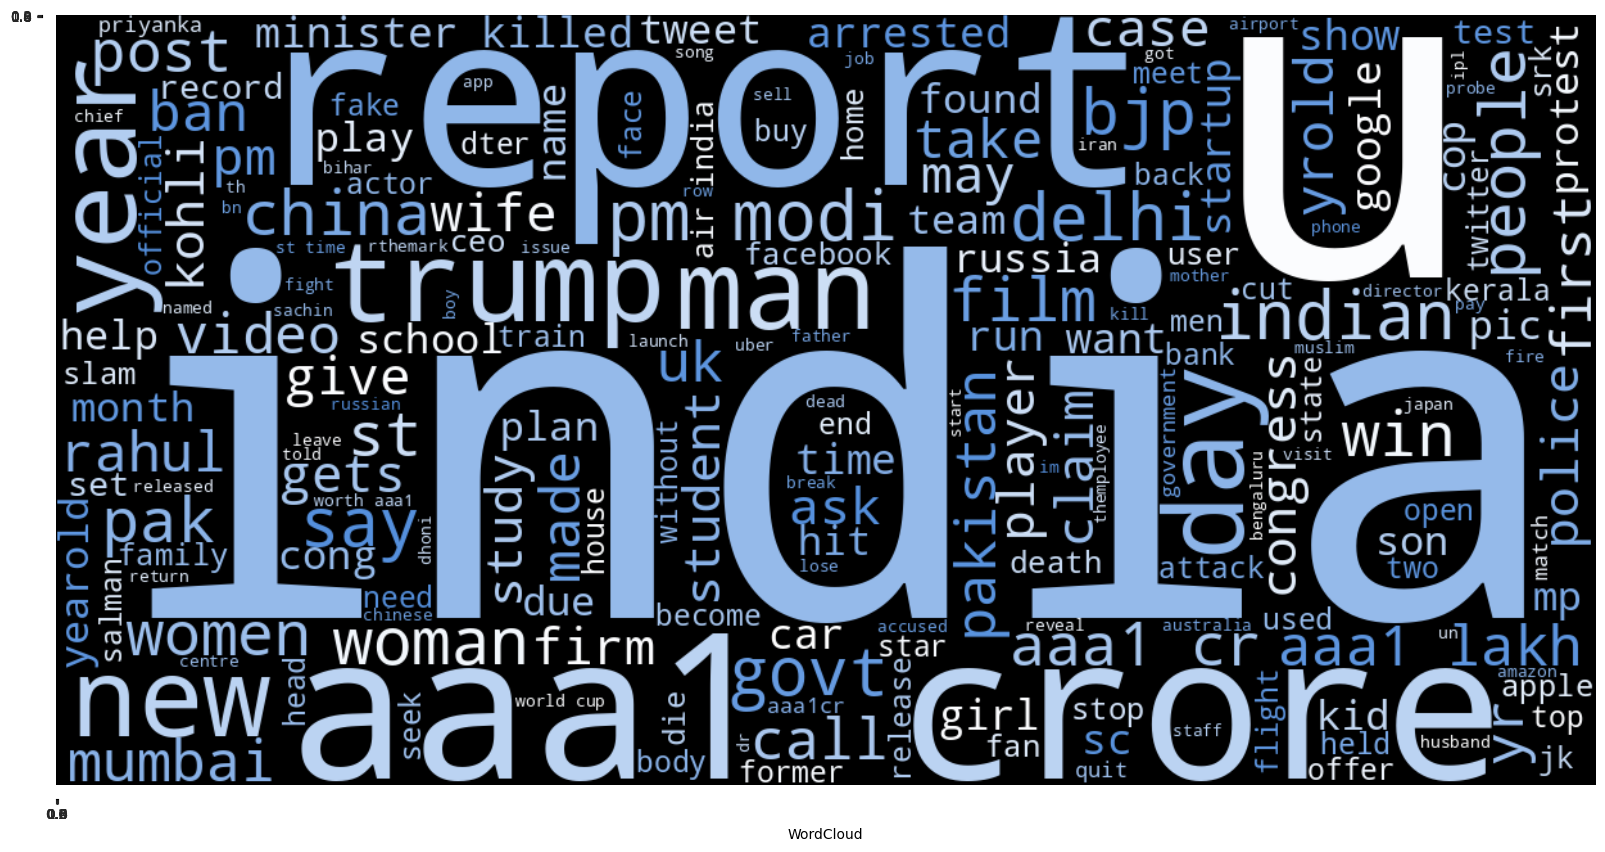

In [24]:
plot_wordcloud(' '.join(df.headlines.values.tolist()), wc_blue_color_func)

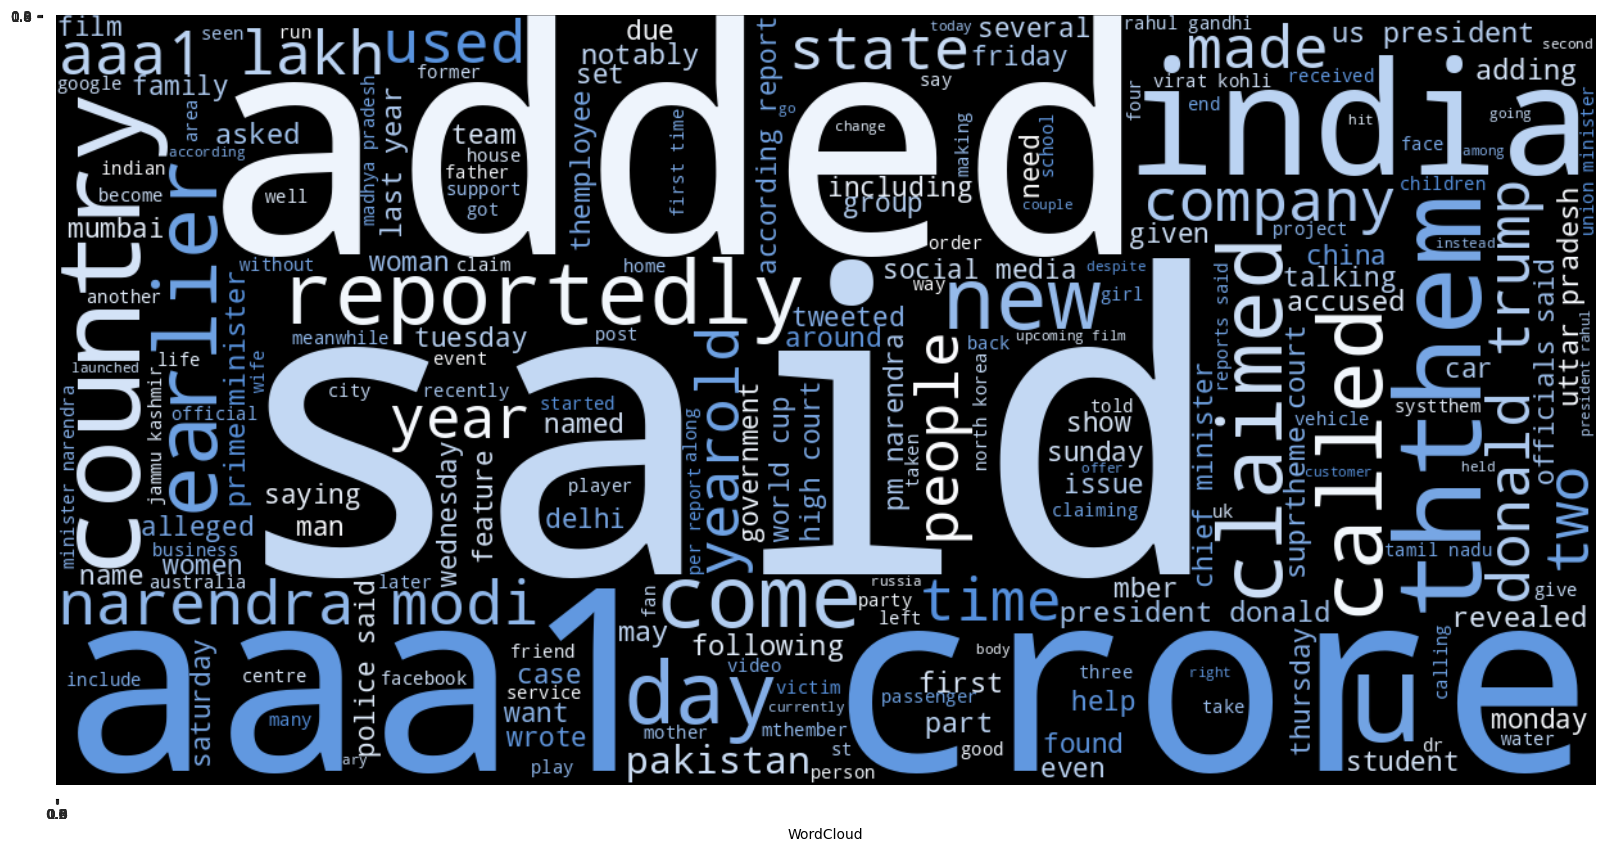

In [25]:
plot_wordcloud(' '.join(df.text.values.tolist()), wc_blue_color_func)

In [26]:
df.headlines = df.headlines.apply(lambda x: f'_START_ {x} _END_')

In [27]:
start_token = 'sostok'
end_token = 'eostok'
df.headlines = df.headlines.apply(lambda x: f'{start_token} {x} {end_token}')

In [28]:
df.sample(5)

,headlines,text
98062,sostok _START_ venezuela holds nationwide mili...,venezuela holding nationwide military drills c...
21299,sostok _START_ take schools extra fee returned...,delhi government take private schools last res...
55194,sostok _START_ bureaucracy misleading people y...,allahabad high court thursday rthemarked burea...
29287,sostok _START_ hero motocorp ceofs aaa1 cr hik...,hero motocorp chairman ceo pawan munjal receiv...
46652,sostok _START_ taliban attack afghanistan kill...,least people killed others injured car bomb at...


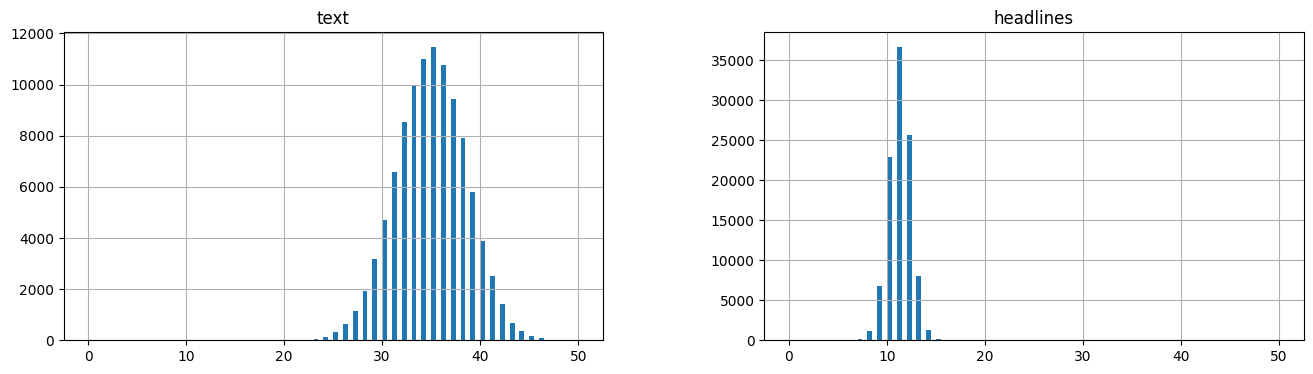

In [29]:
text_count = [len(sentence.split()) for sentence in df.text]
headlines_count = [len(sentence.split()) for sentence in df.headlines]

pd.DataFrame({'text': text_count, 'headlines': headlines_count}).hist(bins=100, figsize=(16, 4), range=[0, 50])
plt.show()

In [30]:
# To check how many rows in a column has length (of the text) <= limit
def get_word_percent(column, limit):
    count = 0
    for sentence in column:
        if len(sentence.split()) <= limit:
            count += 1

    return round(count / len(column), 2)


# Check how many % of headlines have 0-13 words
print(get_word_percent(df.headlines, 13))

# Check how many % of summary have 0-42 words
print(get_word_percent(df.text, 42))

0.99
0.99


In [31]:
max_text_len = 42
max_summary_len = 13

In [32]:
# select the summary and text between their defined max lens respectively
def trim_text_and_summary(df, max_text_len, max_summary_len):
    cleaned_text = np.array(df['text'])
    cleaned_summary = np.array(df['headlines'])

    short_text = []
    short_summary = []

    for i in range(len(cleaned_text)):
        if len(cleaned_text[i].split()) <= max_text_len and len(
            cleaned_summary[i].split()
        ) <= max_summary_len:
            short_text.append(cleaned_text[i])
            short_summary.append(cleaned_summary[i])

    df = pd.DataFrame({'text': short_text, 'summary': short_summary})
    return df


df = trim_text_and_summary(df, max_text_len, max_summary_len)
print(f'Dataset size: {len(df)}')
df.sample(5)

Dataset size: 100258


,text,summary
72843,prime minister narendra modi wednesday said si...,sostok _START_ gdp dipped times upa pm modi _E...
17448,film distributor jp choksey said salman khan f...,sostok _START_ noble initiative distributor co...
19705,hdfc chairman deepak parekh friday said protec...,sostok _START_ indian buy indian says hdfc cha...
73185,union minister mukhtar abbas naqvi friday said...,sostok _START_ terrorism biggest enthemy islam...
89116,cambodias suprtheme court dissolved countrys m...,sostok _START_ cambodian suprtheme court disso...


In [33]:
# rare word analysis
def get_rare_word_percent(tokenizer, threshold):
    # threshold: if the word's occurrence is less than this then it's rare word

    count = 0
    total_count = 0
    frequency = 0
    total_frequency = 0

    for key, value in tokenizer.word_counts.items():
        total_count += 1
        total_frequency += value
        if value < threshold:
            count += 1
            frequency += value

    return {
        'percent': round((count / total_count) * 100, 2),
        'total_coverage': round(frequency / total_frequency * 100, 2),
        'count': count,
        'total_count': total_count
    }

In [34]:
# Splitting the training and testing sets
x_train, x_val, y_train, y_val = train_test_split(
    np.array(df['text']),
    np.array(df['summary']),
    test_size=0.1,
    random_state=123,
    shuffle=True
)

In [35]:
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_train))

x_tokens_data = get_rare_word_percent(x_tokenizer, 4)
print(x_tokens_data)

{'percent': 65.3, 'total_coverage': 2.95, 'count': 65184, 'total_count': 99823}


In [36]:
x_tokenizer = Tokenizer(num_words=x_tokens_data['total_count'] - x_tokens_data['count'])

In [37]:
# else use this
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_train))

In [38]:
# save tokenizer
with open('x_tokenizer', 'wb') as f:
    pickle.dump(x_tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

In [39]:
# one-hot-encoding
x_train_sequence = x_tokenizer.texts_to_sequences(x_train)
x_val_sequence = x_tokenizer.texts_to_sequences(x_val)

# padding upto max_text_len
x_train_padded = pad_sequences(x_train_sequence, maxlen=max_text_len, padding='post')
x_val_padded = pad_sequences(x_val_sequence, maxlen=max_text_len, padding='post')

# if you're not using num_words parameter in Tokenizer then use this
x_vocab_size = len(x_tokenizer.word_index) + 1

# else use this
# x_vocab_size = x_tokenizer.num_words + 1

print(x_vocab_size)

99824


In [40]:
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_train))

y_tokens_data = get_rare_word_percent(y_tokenizer, 4)
print(y_tokens_data)

{'percent': 60.64, 'total_coverage': 3.37, 'count': 22739, 'total_count': 37496}


In [41]:
y_tokenizer = Tokenizer(num_words=y_tokens_data['total_count'] - y_tokens_data['count'])

In [42]:
# else use this
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_train))

In [43]:
# save tokenizer
with open('y_tokenizer', 'wb') as f:
    pickle.dump(y_tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

In [44]:
# one-hot-encoding
y_train_sequence = y_tokenizer.texts_to_sequences(y_train)
y_val_sequence = y_tokenizer.texts_to_sequences(y_val)

# padding upto max_summary_len
y_train_padded = pad_sequences(y_train_sequence, maxlen=max_summary_len, padding='post')
y_val_padded = pad_sequences(y_val_sequence, maxlen=max_summary_len, padding='post')

# if you're not using num_words parameter in Tokenizer then use this
y_vocab_size = len(y_tokenizer.word_index) + 1

# else use this
# y_vocab_size = y_tokenizer.num_words + 1

print(y_vocab_size)

37497


In [45]:
# removing summary which only has sostok & eostok
def remove_indexes(summary_array):
    remove_indexes = []
    for i in range(len(summary_array)):
        count = 0
        for j in summary_array[i]:
            if j != 0:
                count += 1
        if count == 2:
            remove_indexes.append(i)
    return remove_indexes


remove_train_indexes = remove_indexes(y_train_padded)
remove_val_indexes = remove_indexes(y_val_padded)

y_train_padded = np.delete(y_train_padded, remove_train_indexes, axis=0)
x_train_padded = np.delete(x_train_padded, remove_train_indexes, axis=0)

y_val_padded = np.delete(y_val_padded, remove_val_indexes, axis=0)
x_val_padded = np.delete(x_val_padded, remove_val_indexes, axis=0)

In [46]:
latent_dim = 240
embedding_dim = 300
num_epochs = 50

In [47]:
def get_embedding_matrix(tokenizer, embedding_dim, vocab_size=None):
    word_index = tokenizer.word_index
    voc = list(word_index.keys())

    path_to_glove_file = '/content/drive/MyDrive/project/project/glove.6B.300d.txt'

    embeddings_index = {}
    with open('/content/drive/MyDrive/project/project/glove.6B.300d.txt') as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")
            embeddings_index[word] = coefs

    print("Found %s word vectors." % len(embeddings_index))

    num_tokens = len(voc) + 2 if not vocab_size else vocab_size
    hits = 0
    misses = 0

    # Prepare embedding matrix
    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            # This includes the representation for "padding" and "OOV"
            embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1
    print("Converted %d words (%d misses)" % (hits, misses))

    return embedding_matrix


x_embedding_matrix = get_embedding_matrix(x_tokenizer, embedding_dim, x_vocab_size)
y_embedding_matrix = get_embedding_matrix(y_tokenizer, embedding_dim, y_vocab_size)

Found 400000 word vectors.
Converted 55316 words (44507 misses)
Found 400000 word vectors.
Converted 27115 words (10381 misses)


In [48]:
print(x_embedding_matrix.shape)
print(y_embedding_matrix.shape)

(99824, 300)
(37497, 300)


In [49]:
def build_seq2seq_model_with_just_lstm(
    embedding_dim, latent_dim, max_text_len,
    x_vocab_size, y_vocab_size,
    x_embedding_matrix, y_embedding_matrix
):
    # instantiating the model in the strategy scope creates the model on the TPU
    with tpu_strategy.scope():

        # =====================
        # 🔥 Encoder
        # =====================
        encoder_input = Input(shape=(max_text_len, ))

        # encoder embedding layer
        encoder_embedding = Embedding(
            x_vocab_size,
            embedding_dim,
            embeddings_initializer=tf.keras.initializers.Constant(x_embedding_matrix),
            trainable=False
        )(encoder_input)

        # encoder lstm 1
        encoder_lstm1 = LSTM(
            latent_dim,
            return_sequences=True,
            return_state=True,
            dropout=0.4,
            recurrent_dropout=0.4
        )
        encoder_output1, state_h1, state_c1 = encoder_lstm1(encoder_embedding)

        # encoder lstm 2
        encoder_lstm2 = LSTM(
            latent_dim,
            return_sequences=True,
            return_state=True,
            dropout=0.4,
            recurrent_dropout=0.4
        )
        encoder_output, *encoder_final_states = encoder_lstm2(encoder_output1)

        # =====================
        # 🌈 Decoder
        # =====================

        # Set up the decoder, using `encoder_states` as initial state.

        decoder_input = Input(shape=(None, ))

        # decoder embedding layer
        decoder_embedding_layer = Embedding(
            y_vocab_size,
            embedding_dim,
            embeddings_initializer=tf.keras.initializers.Constant(y_embedding_matrix),
            trainable=True
        )
        decoder_embedding = decoder_embedding_layer(decoder_input)

        # decoder lstm 1
        decoder_lstm = LSTM(
            latent_dim,
            return_sequences=True,
            return_state=True,
            dropout=0.4,
            recurrent_dropout=0.4
        )
        decoder_output, *decoder_final_states = decoder_lstm(
            decoder_embedding, initial_state=encoder_final_states
        )

        # dense layer
        decoder_dense = TimeDistributed(
            Dense(y_vocab_size, activation='softmax')
        )
        decoder_output = decoder_dense(decoder_output)

        # =====================
        # ⚡️ Model
        # =====================
        model = Model([encoder_input, decoder_input], decoder_output)
        model.summary()

        optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01)
        model.compile(
            optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        return {
            'model': model,
            'inputs': {
                'encoder': encoder_input,
                'decoder': decoder_input
            },
            'outputs': {
                'encoder': encoder_output,
                'decoder': decoder_output
            },
            'states': {
                'encoder': encoder_final_states,
                'decoder': decoder_final_states
            },
            'layers': {
                'decoder': {
                    'embedding': decoder_embedding_layer,
                    'last_decoder_lstm': decoder_lstm,
                    'dense': decoder_dense
                }
            }
        }

In [50]:
def build_seq2seq_model_with_bidirectional_lstm(
    embedding_dim, latent_dim, max_text_len,
    x_vocab_size, y_vocab_size,
    x_embedding_matrix, y_embedding_matrix
):
    # instantiating the model in the strategy scope creates the model on the TPU
    with tpu_strategy.scope():

        # =====================
        # 🔥 Encoder
        # =====================
        encoder_input = Input(shape=(max_text_len, ))

        # encoder embedding layer
        encoder_embedding = Embedding(
            x_vocab_size,
            embedding_dim,
            embeddings_initializer=tf.keras.initializers.Constant(x_embedding_matrix),
            trainable=False,
            name='encoder_embedding'
        )(encoder_input)

        # encoder lstm1
        encoder_bi_lstm1 = Bidirectional(
            LSTM(
                latent_dim,
                return_sequences=True,
                return_state=True,
                dropout=0.4,
                recurrent_dropout=0.4,
                name='encoder_lstm_1'
            ),
            name='encoder_bidirectional_lstm_1'
        )
        encoder_output1, forward_h1, forward_c1, backward_h1, backward_c1 = encoder_bi_lstm1(
            encoder_embedding
        )
        encoder_bi_lstm1_output = [
            encoder_output1, forward_h1, forward_c1, backward_h1, backward_c1
        ]

        # encoder lstm 2
        encoder_bi_lstm2 = Bidirectional(
            LSTM(
                latent_dim,
                return_sequences=True,
                return_state=True,
                dropout=0.4,
                recurrent_dropout=0.4,
                name='encoder_lstm_2'
            ),
            name='encoder_bidirectional_lstm_2'
        )
        encoder_output2, forward_h2, forward_c2, backward_h2, backward_c2 = encoder_bi_lstm2(
            encoder_output1
        )
        encoder_bi_lstm2_output = [
            encoder_output2, forward_h2, forward_c2, backward_h2, backward_c2
        ]

        # encoder lstm 3
        encoder_bi_lstm = Bidirectional(
            LSTM(
                latent_dim,
                return_sequences=True,
                return_state=True,
                dropout=0.4,
                recurrent_dropout=0.4,
                name='encoder_lstm_3'
            ),
            name='encoder_bidirectional_lstm_3'
        )
        encoder_output, *encoder_final_states = encoder_bi_lstm(encoder_output2)

        # =====================
        # 🌈 Decoder
        # =====================

        # Set up the decoder, using `encoder_states` as initial state.

        decoder_input = Input(shape=(None, ))

        # decoder embedding layer
        decoder_embedding_layer = Embedding(
            y_vocab_size,
            embedding_dim,
            embeddings_initializer=tf.keras.initializers.Constant(y_embedding_matrix),
            trainable=False,
            name='decoder_embedding'
        )
        decoder_embedding = decoder_embedding_layer(decoder_input)

        decoder_bi_lstm = Bidirectional(
            LSTM(
                latent_dim,
                return_sequences=True,
                return_state=True,
                dropout=0.4,
                recurrent_dropout=0.2,
                name='decoder_lstm_1'
            ),
            name='decoder_bidirectional_lstm_1'
        )
        decoder_output, *decoder_final_states = decoder_bi_lstm(
            decoder_embedding, initial_state=encoder_final_states
            # decoder_embedding, initial_state=encoder_final_states[:2]
        )  # taking only the forward states

        # dense layer
        decoder_dense = TimeDistributed(
            Dense(y_vocab_size, activation='softmax')
        )
        decoder_output = decoder_dense(decoder_output)

        # =====================
        # ⚡️ Model
        # =====================
        model = Model([encoder_input, decoder_input], decoder_output, name='seq2seq_model_with_bidirectional_lstm')
        model.summary()

        optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
        model.compile(
            optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        return {
            'model': model,
            'inputs': {
                'encoder': encoder_input,
                'decoder': decoder_input
            },
            'outputs': {
                'encoder': encoder_output,
                'decoder': decoder_output
            },
            'states': {
                'encoder': encoder_final_states,
                'decoder': decoder_final_states
            },
            'layers': {
                'decoder': {
                    'embedding': decoder_embedding_layer,
                    'last_decoder_lstm': decoder_bi_lstm,
                    'dense': decoder_dense
                }
            }
        }

In [51]:
def build_hybrid_seq2seq_model(
    embedding_dim, latent_dim, max_text_len,
    x_vocab_size, y_vocab_size,
    x_embedding_matrix, y_embedding_matrix
):
    # instantiating the model in the strategy scope creates the model on the TPU
    with tpu_strategy.scope():

        # =====================
        # 🔥 Encoder
        # =====================
        encoder_input = Input(shape=(max_text_len, ))

        # encoder embedding layer
        encoder_embedding = Embedding(
            x_vocab_size,
            embedding_dim,
            embeddings_initializer=tf.keras.initializers.Constant(x_embedding_matrix),
            trainable=False,
            name='encoder_embedding'
        )(encoder_input)

        # encoder lstm1
        encoder_bi_lstm1 = Bidirectional(
            LSTM(
                latent_dim,
                return_sequences=True,
                return_state=True,
                dropout=0.4,
                recurrent_dropout=0.4,
                name='encoder_lstm_1'
            ),
            name='encoder_bidirectional_lstm_1'
        )
        encoder_output1, forward_h1, forward_c1, backward_h1, backward_c1 = encoder_bi_lstm1(
            encoder_embedding
        )
        encoder_bi_lstm1_output = [
            encoder_output1, forward_h1, forward_c1, backward_h1, backward_c1
        ]

        # encoder lstm 2
        encoder_bi_lstm2 = Bidirectional(
            LSTM(
                latent_dim,
                return_sequences=True,
                return_state=True,
                dropout=0.4,
                recurrent_dropout=0.4,
                name='encoder_lstm_2'
            ),
            name='encoder_bidirectional_lstm_2'
        )
        encoder_output2, forward_h2, forward_c2, backward_h2, backward_c2 = encoder_bi_lstm2(
            encoder_output1
        )
        encoder_bi_lstm2_output = [
            encoder_output2, forward_h2, forward_c2, backward_h2, backward_c2
        ]

        # encoder lstm 3
        encoder_bi_lstm = Bidirectional(
            LSTM(
                latent_dim,
                return_sequences=True,
                return_state=True,
                dropout=0.4,
                recurrent_dropout=0.4,
                name='encoder_lstm_3'
            ),
            name='encoder_bidirectional_lstm_3'
        )
        encoder_output, *encoder_final_states = encoder_bi_lstm(encoder_output2)

        # =====================
        # 🌈 Decoder
        # =====================

        # Set up the decoder, using `encoder_states` as initial state.

        decoder_input = Input(shape=(None, ))

        # decoder embedding layer
        decoder_embedding_layer = Embedding(
            y_vocab_size,
            embedding_dim,
            embeddings_initializer=tf.keras.initializers.Constant(y_embedding_matrix),
            trainable=False,
            name='decoder_embedding'
        )
        decoder_embedding = decoder_embedding_layer(decoder_input)

        decoder_lstm = LSTM(
            latent_dim,
            return_sequences=True,
            return_state=True,
            dropout=0.4,
            recurrent_dropout=0.2,
            name='decoder_lstm_1'
        )
        decoder_output, *decoder_final_states = decoder_lstm(
            decoder_embedding, initial_state=encoder_final_states[:2]
        )  # taking only the forward states

        # dense layer
        decoder_dense = TimeDistributed(
            Dense(y_vocab_size, activation='softmax')
        )
        decoder_output = decoder_dense(decoder_output)

        # =====================
        # ⚡️ Model
        # =====================
        model = Model([encoder_input, decoder_input], decoder_output, name='seq2seq_model_with_bidirectional_lstm')
        model.summary()

        optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
        model.compile(
            optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        return {
            'model': model,
            'inputs': {
                'encoder': encoder_input,
                'decoder': decoder_input
            },
            'outputs': {
                'encoder': encoder_output,
                'decoder': decoder_output
            },
            'states': {
                'encoder': encoder_final_states,
                'decoder': decoder_final_states
            },
            'layers': {
                'decoder': {
                    'embedding': decoder_embedding_layer,
                    'last_decoder_lstm': decoder_lstm,
                    'dense': decoder_dense
                }
            }
        }

In [52]:
seq2seq = build_seq2seq_model_with_just_lstm(
    embedding_dim, latent_dim, max_text_len,
    x_vocab_size, y_vocab_size,
    x_embedding_matrix, y_embedding_matrix
)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 42)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 42, 300)      29947200    ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 42, 240),    519360      ['embedding[0][0]']              
                                 (None, 240),                                                 

In [53]:
model = seq2seq['model']

encoder_input = seq2seq['inputs']['encoder']
decoder_input = seq2seq['inputs']['decoder']

encoder_output = seq2seq['outputs']['encoder']
decoder_output = seq2seq['outputs']['decoder']

encoder_final_states = seq2seq['states']['encoder']
decoder_final_states = seq2seq['states']['decoder']

decoder_embedding_layer = seq2seq['layers']['decoder']['embedding']
last_decoder_lstm = seq2seq['layers']['decoder']['last_decoder_lstm']
decoder_dense = seq2seq['layers']['decoder']['dense']

In [54]:
model.layers[-2].input

[<KerasTensor: shape=(None, None, 300) dtype=float32 (created by layer 'embedding_1')>,
 <KerasTensor: shape=(None, 240) dtype=float32 (created by layer 'lstm_1')>,
 <KerasTensor: shape=(None, 240) dtype=float32 (created by layer 'lstm_1')>]

In [55]:
callbacks = [
    EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.001, verbose=1),
]

In [56]:
history = model.fit(
    [x_train_padded, y_train_padded[:, :-1]],
    y_train_padded.reshape(y_train_padded.shape[0], y_train_padded.shape[1], 1)[:, 1:],
    epochs=50,
    batch_size=128* tpu_strategy.num_replicas_in_sync,
    callbacks=callbacks,
    validation_data=(
        [x_val_padded, y_val_padded[:, :-1]],
        y_val_padded.reshape(y_val_padded.shape[0], y_val_padded.shape[1], 1)[:, 1:]
    )
)

Epoch 1/50
89/89 [==============================] - 57s 382ms/step - loss: 5.7920 - accuracy: 0.3712 - val_loss: 5.1170 - val_accuracy: 0.4321 - lr: 0.0100
Epoch 2/50
89/89 [==============================] - 12s 141ms/step - loss: 5.1502 - accuracy: 0.4215 - val_loss: 4.9716 - val_accuracy: 0.4355 - lr: 0.0100
Epoch 3/50
89/89 [==============================] - 10s 110ms/step - loss: 5.0359 - accuracy: 0.4241 - val_loss: 4.8780 - val_accuracy: 0.4356 - lr: 0.0100
Epoch 4/50
89/89 [==============================] - 9s 106ms/step - loss: 4.9363 - accuracy: 0.4268 - val_loss: 4.7910 - val_accuracy: 0.4396 - lr: 0.0100
Epoch 5/50
89/89 [==============================] - 9s 106ms/step - loss: 4.8496 - accuracy: 0.4294 - val_loss: 4.7190 - val_accuracy: 0.4417 - lr: 0.0100
Epoch 6/50
89/89 [==============================] - 10s 107ms/step - loss: 4.7754 - accuracy: 0.4318 - val_loss: 4.6912 - val_accuracy: 0.4386 - lr: 0.0100
Epoch 7/50
89/89 [==============================] - 9s 106ms/step 

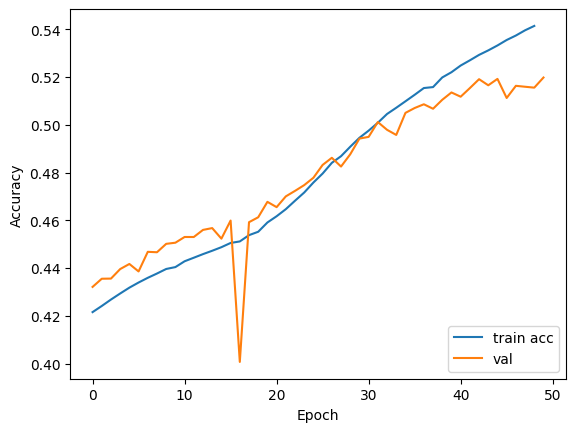

In [57]:
# Accuracy
plt.plot(history.history['accuracy'][1:], label='train acc')
plt.plot(history.history['val_accuracy'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

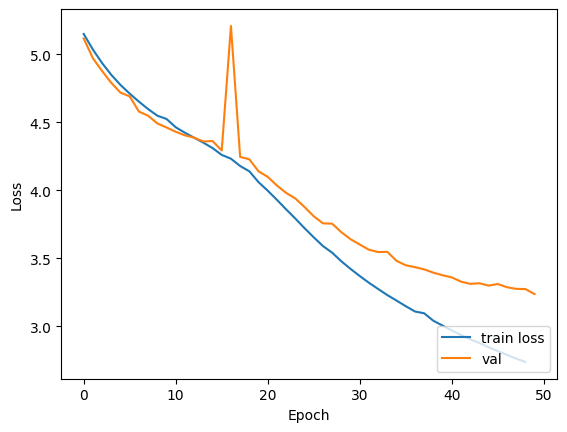

In [58]:
# Loss
plt.plot(history.history['loss'][1:], label='train loss')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

In [59]:
import pickle

In [64]:
filename =  "Trained_model.sav"
pickle.dump(history, open(filename , 'wb'))

In [ ]:
loaded_model =  pickle.load(open('Trained_model.sav','rb'))

In [1]:
!jupyter nbconvert --to script ATSFNB.ipynb

[NbConvertApp] Converting notebook ATSFNB.ipynb to script
[NbConvertApp] Writing 28982 bytes to ATSFNB.txt
